In [3]:
import numpy as np
import pandas as pd
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import cv2 as cv

In [4]:
DATA_PATH = "data/echonet-dynamic"

### Explore VolumeTracings.csv

In [5]:
tracings = pd.read_csv(f"{DATA_PATH}/VolumeTracings.csv")
tracings.shape

(425010, 6)

In [6]:
file_name = "0X100CF05D141FF143.avi"
frame_code = list(tracings[tracings["FileName"] == file_name]["Frame"].unique())[0]
frame_codes = list(tracings[tracings["FileName"] == file_name]["Frame"].unique())

vid_cap = cv.VideoCapture(f"{DATA_PATH}/Videos/{file_name}")
success, frame = vid_cap.read()
count = 0
while success:
  success, frame = vid_cap.read()
  if count == frame_code:
    im = frame
    success = False
  count += 1
frame_img = im

In [7]:
tracings.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


How many "masked" frames we have for each video?

In [8]:
set(tracings.groupby(["FileName"])["Frame"].nunique())

{2}

How many frames can we obtain in total?

In [9]:
len(tracings["FileName"].unique()) * 2

20050

### Example of Frame + Mask

In [10]:
def plot_example(file, frame_nums):
  plt.ion()

  print(f"File --> {file}")
  fig, axs = plt.subplots(len(frame_nums), 3, figsize=(15, 8))
  fig.set_facecolor("white")
  plt.suptitle(f"File: {file}, Frames: {frame_nums}")

  for idx, frame_num in enumerate(frame_nums):

    axs[idx, 0].set_xticks([]); axs[idx, 1].set_xticks([]); axs[idx, 2].set_xticks([])
    axs[idx, 0].set_yticks([]); axs[idx, 1].set_yticks([]); axs[idx, 2].set_yticks([])
    axs[idx, 0].set_xlim(0, 112); axs[idx, 1].set_xlim(0, 112); axs[idx, 2].set_xlim(0, 112)
    axs[idx, 0].set_ylim(112, 0); axs[idx, 1].set_ylim(112, 0); axs[idx, 2].set_ylim(112, 0)

    # plot weak label
    ex1 = tracings[
        (tracings.Frame == frame_num) & (tracings.FileName == file)
    ]
    lines = []
    for index, row in ex1.iterrows():
      (x1, y1) = row['X1'], row['Y1']
      (x2, y2) = row['X2'], row['Y2']
      point = [(x1, y1), (x2, y2)]
      lines.append(point)
    lc = mc.LineCollection(lines, linewidths=1)
    axs[idx, 0].add_collection(lc)

    # plot frame
    vid_cap = cv.VideoCapture(f"{DATA_PATH}/Videos/{file}")
    success, frame = vid_cap.read()
    count = 0
    while success:
      success, frame = vid_cap.read()
      if count == frame_num:
        axs[idx, 1].imshow(frame)
        success = False
      count += 1

    lc = mc.LineCollection(lines, colors=["red"], linewidths=1)
    axs[idx, 2].imshow(frame)
    axs[idx, 2].add_collection(lc)
  plt.show()
  plt.close()

File --> 0X100CF05D141FF143.avi


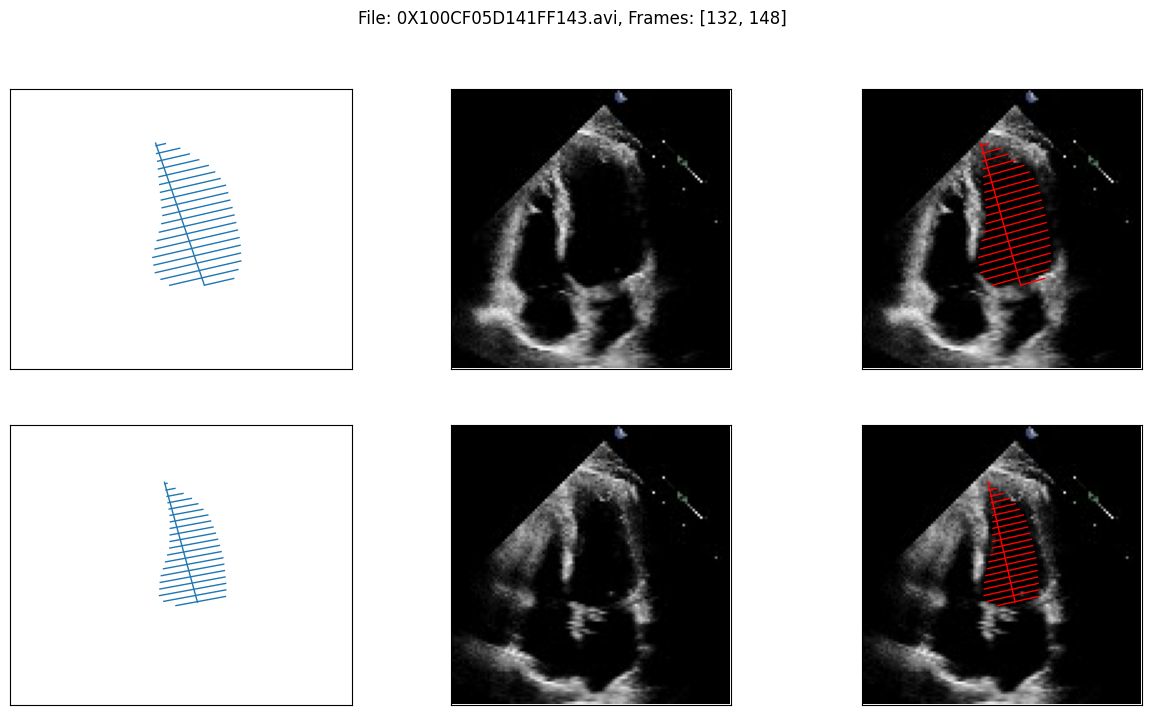

In [11]:
plot_example(file_name, frame_codes)

## How to obtain the binary mask?

### Using skimage

In [12]:
from skimage.morphology import convex_hull_image
from skimage.util import img_as_ubyte

In [13]:
def mask_data(X, Y, im):
    X = np.round(X).astype(int)
    Y = np.round(Y).astype(int)

    # Create an empty mask
    BW = np.zeros_like(im, dtype=bool)

    # Mark the specified coordinates
    for x, y in zip(X, Y):
        BW[y, x] = True

    # Convert mask to uint8 format
    BW = img_as_ubyte(BW)

    # Compute the convex hull of the binary mask
    BW = convex_hull_image(BW)

    # Convert the convex hull mask to uint8
    BW = img_as_ubyte(BW)

    # Display the mask
    return BW

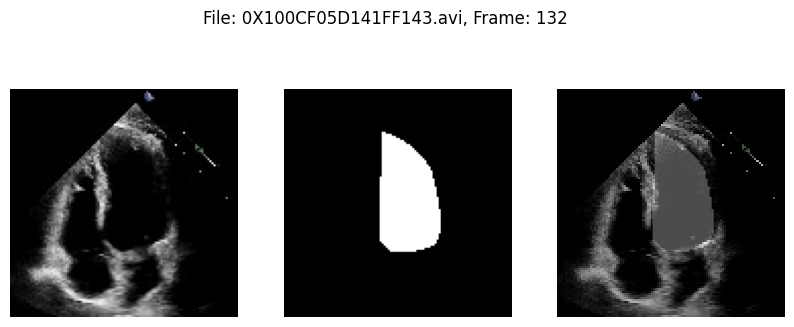

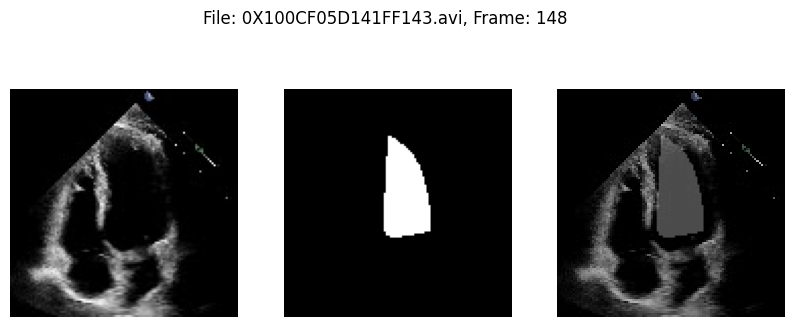

In [14]:
for frame_code in frame_codes:
  plt.figure(figsize=(10,4))
  plt.suptitle(f"File: {file_name}, Frame: {frame_code}")
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(frame_img)

  # Example usage:
  ex1 = tracings[(tracings.Frame == frame_code) & (tracings.FileName == file_name)]
  x = np.array(list(ex1.X1) + list(ex1.X2))
  y = np.array(list(ex1.Y1) + list(ex1.Y2))
  plt.subplot(1,3,2)
  plt.axis("off")
  mask = mask_data(x, y, im)
  plt.imshow(mask, cmap='gray')

  plt.subplot(1,3,3)
  plt.axis("off")
  plt.imshow(frame_img, 'gray', interpolation='none')
  plt.imshow(mask, alpha=0.3)
  plt.show()

### Using plt + CV libraries

In [15]:
def save_obs(file, f_num):
  plt.ioff()
  px = 1/plt.rcParams['figure.dpi']

  # plot weak label
  fig, ax = plt.subplots(figsize=(112*px,112*px))
  ex1 = tracings[
      (tracings.Frame == f_num) & (tracings.FileName == file)
  ]
  lines = []
  for index, row in ex1.iterrows():
    (x1, y1) = row['X1'], -row['Y1']
    (x2, y2) = row['X2'], -row['Y2']
    point = [(x1, y1), (x2, y2)]
    lines.append(point)
  lc = mc.LineCollection(lines, linewidths=2)
  ax.set_xlim(0,112)
  ax.set_ylim(-112,0)
  ax.add_collection(lc)
  plt.axis("off")
  # save mask as png file
  plt.savefig(f"mask_{f_num}.png")

  # plot frame
  vid_cap = cv.VideoCapture(f"{DATA_PATH}/Videos/{file}")
  success, frame = vid_cap.read()
  count = 0
  while success:
    success, frame = vid_cap.read()
    if count == f_num:
      # save frame as png file
      cv.imwrite(f"frame_{f_num}.png", frame[:,:,0])
    count += 1

In [16]:
save_obs(file_name, frame_code)
print(f"Mask shape --> {cv.imread(f'mask_{frame_code}.png').shape}")
print(f"Frame shape --> {cv.imread(f'frame_{frame_code}.png').shape}")

Mask shape --> (112, 112, 3)
Frame shape --> (112, 112, 3)


In [17]:
img = cv.imread(f'frame_{frame_code}.png')
print(f"Min: {img[:,:,0].min()} \t Max: {img[:,:,0].max()} \t Avg: {np.mean(img[:,:,0])}")
print(f"Min: {img[:,:,1].min()} \t Max: {img[:,:,1].max()} \t Avg: {np.mean(img[:,:,1])}")
print(f"Min: {img[:,:,2].min()} \t Max: {img[:,:,2].max()} \t Avg: {np.mean(img[:,:,2])}")

Min: 0 	 Max: 252 	 Avg: 22.019052933673468
Min: 0 	 Max: 252 	 Avg: 22.019052933673468
Min: 0 	 Max: 252 	 Avg: 22.019052933673468


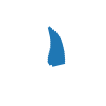

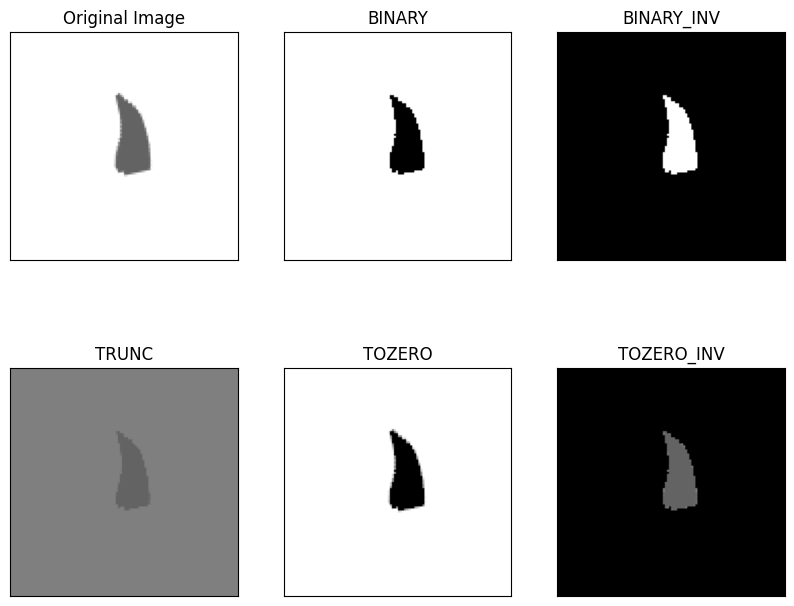

In [18]:
img = cv.imread(f"mask_{frame_code}.png", cv.IMREAD_GRAYSCALE)
_, thresh1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
_, thresh2 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
_, thresh3 = cv.threshold(img, 127, 255, cv.THRESH_TRUNC)
_, thresh4 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)
_, thresh5 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO_INV)

titles = ['Original Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

plt.figure(figsize=(10, 8))
for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.imshow(images[i], 'gray', vmin=0, vmax=255)
  plt.title(titles[i])
  plt.xticks([]), plt.yticks([])

plt.show()

In [19]:
# Original image
print(f"Min value --> {img.min()}")
print(f"Max value --> {img.max()}")
print(f"Values --> {set(img.flatten())}")

Min value --> 99
Max value --> 255
Values --> {99, 100, 101, 102, 105, 106, 108, 109, 111, 113, 115, 121, 122, 123, 124, 125, 128, 131, 133, 136, 137, 139, 140, 141, 142, 144, 145, 146, 148, 150, 156, 157, 158, 159, 168, 170, 173, 174, 176, 177, 178, 185, 190, 191, 193, 201, 203, 205, 207, 208, 209, 210, 211, 212, 214, 217, 218, 219, 220, 221, 225, 227, 228, 230, 231, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 249, 250, 251, 252, 253, 254, 255}


In [20]:
# Binary image
print(f"Min value --> {thresh2.min()}")
print(f"Max value --> {thresh2.max()}")
print(f"Values --> {set(thresh2.flatten())}")

Min value --> 0
Max value --> 255
Values --> {0, 255}


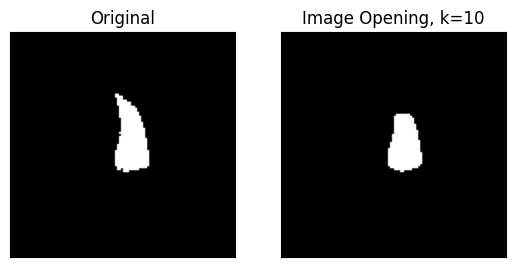

In [21]:
# Original
plt.subplot(1, 2, 1)
plt.imshow(thresh2, 'gray', vmin=0, vmax=255)
plt.title("Original")
plt.xticks([]), plt.yticks([])

# Image opening
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10))
res = cv.morphologyEx(thresh2, cv.MORPH_OPEN, kernel)
plt.subplot(1, 2, 2)
plt.imshow(res, 'gray', vmin=0, vmax=255)
plt.title("Image Opening, k=10")
plt.xticks([]), plt.yticks([])

# Show
plt.show()

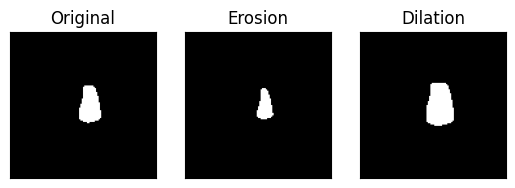

In [22]:
# smooth contours
img = res
plt.subplot(1, 3, 1)
plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.imshow(img, 'gray', vmin=0, vmax=255)

# kernel size
kernel = np.ones((5, 5), np.uint8)

plt.subplot(1,3,2)
plt.title("Erosion")
plt.xticks([]), plt.yticks([])
erosion = cv.erode(img, kernel, iterations=1)
plt.imshow(erosion, 'gray', vmin=0, vmax=255)

plt.subplot(1,3,3)
plt.title("Dilation")
plt.xticks([]), plt.yticks([])
dilation = cv.dilate(img, kernel, iterations = 1)
plt.imshow(dilation, 'gray', vmin=0, vmax=255)

plt.show()

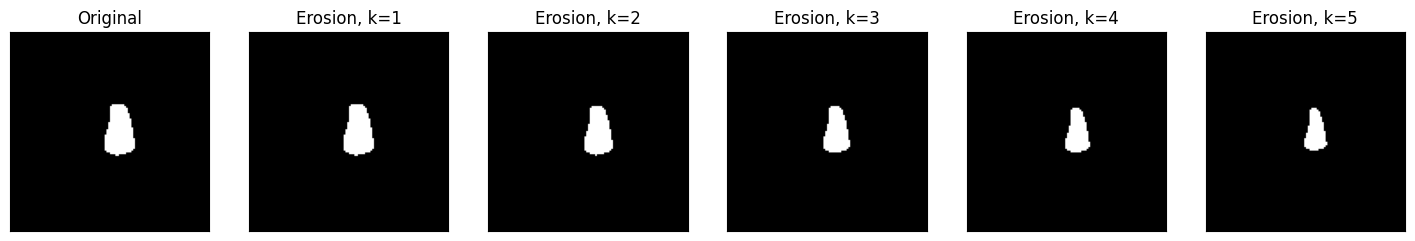

In [23]:
# decrease erosion kernel
plt.figure(figsize=(18,3))

plt.subplot(1, 6, 1)
plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.imshow(img, 'gray', vmin=0, vmax=255)

for i in range(5):
  plt.subplot(1,6,i+2)
  plt.title(f"Erosion, k={i+1}")
  plt.xticks([]), plt.yticks([])
  kernel = np.ones((i+1, i+1), np.uint8)
  erosion = cv.erode(img, kernel, iterations=1)
  plt.imshow(erosion, 'gray', vmin=0, vmax=255)

plt.show()

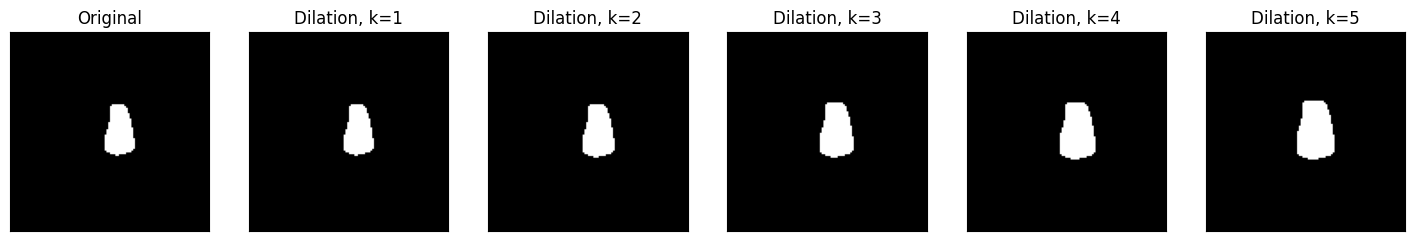

In [24]:
# decrease erosion kernel
plt.figure(figsize=(18,3))

plt.subplot(1, 6, 1)
plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.imshow(img, 'gray', vmin=0, vmax=255)

for i in range(5):
  plt.subplot(1,6,i+2)
  plt.title(f"Dilation, k={i+1}")
  plt.xticks([]), plt.yticks([])
  kernel = np.ones((i+1, i+1), np.uint8)
  dilate = cv.dilate(img, kernel, iterations=1)
  plt.imshow(dilate, 'gray', vmin=0, vmax=255)
plt.show()

The best option (at a glance) seems to be dilation with kernel size = 2

## Compare Methods to obtain Binary Mask

### Method 1: skimage

In [25]:
def method_1(ex, f_im):
  x = np.array(list(ex.X1) + list(ex.X2))
  y = np.array(list(ex.Y1) + list(ex.Y2))
  m = mask_data(x, y, f_im)
  return m

### Method 2: plt + cv

In [26]:
def method_2(f_name, f_code):
  m = cv.imread(f"mask_{f_code}.png", cv.IMREAD_GRAYSCALE)
  _, bin_inv = cv.threshold(m, 127, 255, cv.THRESH_BINARY_INV)
  k = np.ones((2, 2), np.uint8)
  d_mask = cv.dilate(bin_inv, k, iterations = 1)
  return d_mask

### Comparison

In [27]:
# Data
file_name = "0X100CF05D141FF143.avi"
frame_code = list(tracings[tracings["FileName"] == file_name]["Frame"].unique())[0]
frame_codes = list(tracings[tracings["FileName"] == file_name]["Frame"].unique())

# --------------------------------------------------------------------------------

print(f"File --> {file_name}")
_, axs = plt.subplots(len(frame_codes), 5, figsize=(20, 8))
plt.suptitle(f"File: {file_name}, Frames: {frame_codes}")

for idx, frame_num in enumerate(frame_codes):

  save_obs(file_name, frame_num)
  plt.ion()

  axs[idx, 0].set_xticks([]); axs[idx, 1].set_xticks([]); axs[idx, 2].set_xticks([]); axs[idx, 3].set_xticks([]); axs[idx, 4].set_xticks([])
  axs[idx, 0].set_yticks([]); axs[idx, 1].set_yticks([]); axs[idx, 2].set_yticks([]); axs[idx, 3].set_yticks([]); axs[idx, 4].set_yticks([])
  axs[idx, 0].set_xlim(0, 112); axs[idx, 1].set_xlim(0, 112); axs[idx, 2].set_xlim(0, 112); axs[idx, 3].set_xlim(0, 112); axs[idx, 4].set_xlim(0, 112)
  axs[idx, 0].set_ylim(112, 0); axs[idx, 1].set_ylim(112, 0); axs[idx, 2].set_ylim(112, 0); axs[idx, 3].set_ylim(112, 0); axs[idx, 4].set_ylim(112, 0)

  # plot weak label
  ex1 = tracings[
      (tracings.Frame == frame_num) & (tracings.FileName == file_name)
  ]
  lines = []
  for index, row in ex1.iterrows():
    (x1, y1) = row['X1'], row['Y1']
    (x2, y2) = row['X2'], row['Y2']
    point = [(x1, y1), (x2, y2)]
    lines.append(point)
  lc = mc.LineCollection(lines, linewidths=1)
  axs[idx, 0].add_collection(lc)

  # plot original frame
  vid_cap = cv.VideoCapture(f"{DATA_PATH}/Videos/{file_name}")
  success, frame = vid_cap.read()
  count = 0
  while success:
    success, frame = vid_cap.read()
    if count == frame_num:
      axs[idx, 1].imshow(frame)
      success = False
    count += 1

  # plot weak label + original frame
  lc = mc.LineCollection(lines, colors=["red"], linewidths=1)
  axs[idx, 2].imshow(frame)
  axs[idx, 2].add_collection(lc)

  # method 1: plot label + original frame
  mask_method1 = method_1(ex1, frame)
  axs[idx, 3].imshow(frame)
  axs[idx, 3].imshow(mask_method1)

  # method 2: plot label + original frame
  mask_method2 = method_2(file_name, frame_num)
  axs[idx, 4].imshow(frame)
  axs[idx, 4].imshow(mask_method2, cmap="gray")

File --> 0X100CF05D141FF143.avi


In [28]:
m = cv.imread(f"mask_{frame_code}.png")
m.shape

(112, 112, 3)

In [29]:
f = cv.imread(f"frame_{frame_code}.png", cv.IMREAD_GRAYSCALE)
f.shape

(112, 112)

## Improve Images

In [30]:
f = cv.imread(f"frame_{frame_code}.png", cv.IMREAD_GRAYSCALE)

In [31]:
def print_results(before, after, sup_title):
  fig = plt.figure(figsize=(10,10))
  plt.suptitle(sup_title, y=0.77, fontweight="bold")

  plt.subplot(1, 2, 1)
  plt.title("Before")
  plt.axis("off")
  plt.imshow(before, cmap="gray")

  plt.subplot(1, 2, 2)
  plt.title("After")
  plt.axis("off")
  plt.imshow(after, cmap="gray")

  plt.show()

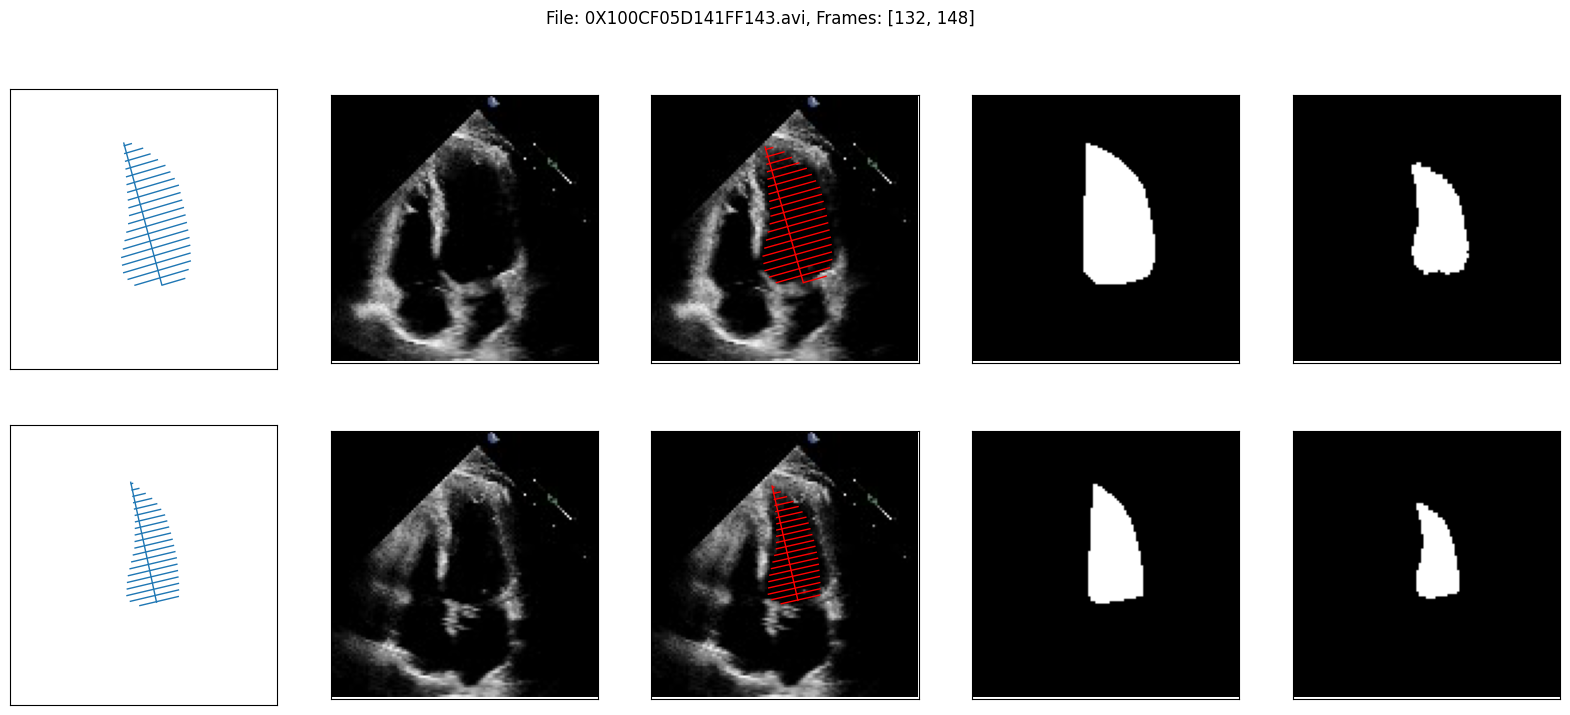

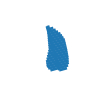

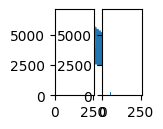

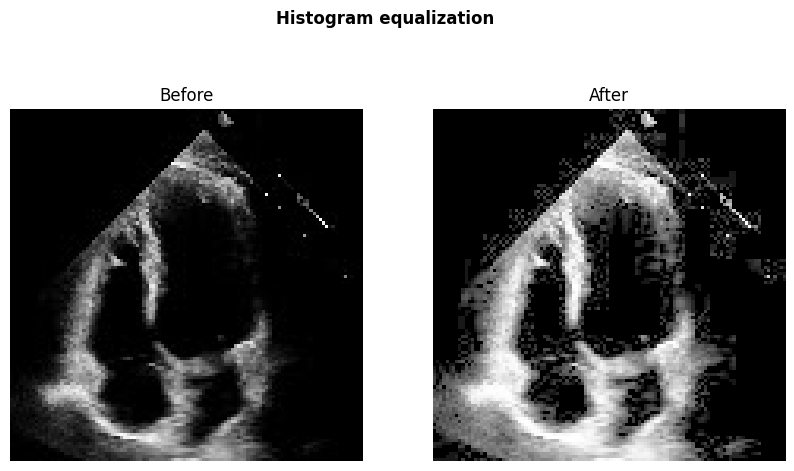

In [32]:
eq_img = cv.equalizeHist(f)
plt.subplot(1,2,1)
plt.hist(f.flatten(),256,[0,256])
plt.xlim([0,256])
plt.subplot(1,2,2)
plt.hist(eq_img.flatten(),256,[0,256])
plt.xlim([0,256])
print_results(f, eq_img, "Histogram equalization")

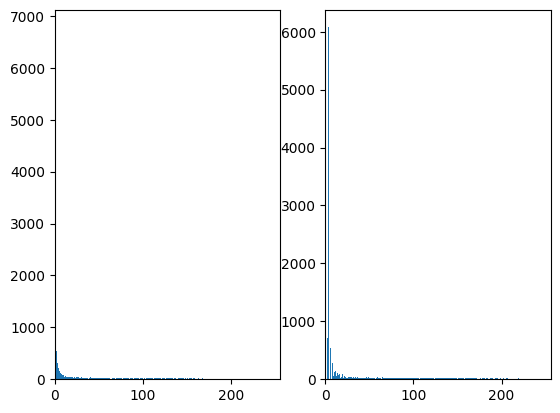

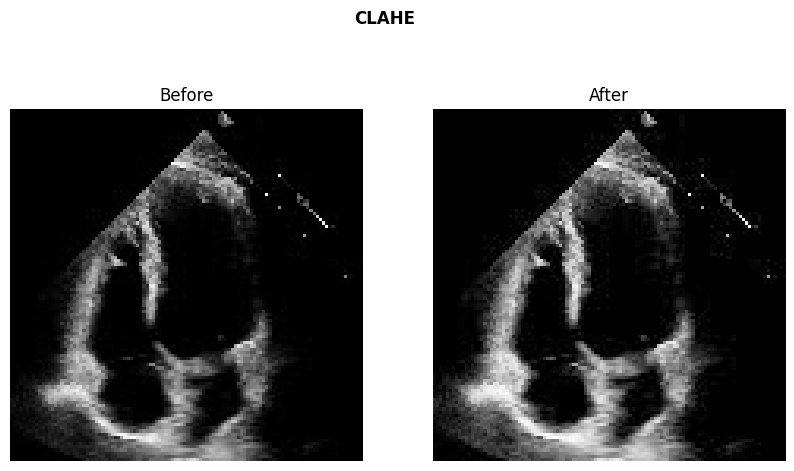

In [33]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
cl1 = clahe.apply(f)
plt.subplot(1,2,1)
plt.hist(f.flatten(),256,[0,256])
plt.xlim([0,256])
plt.subplot(1,2,2)
plt.hist(cl1.flatten(),256,[0,256])
plt.xlim([0,256])
print_results(f, cl1, "CLAHE")

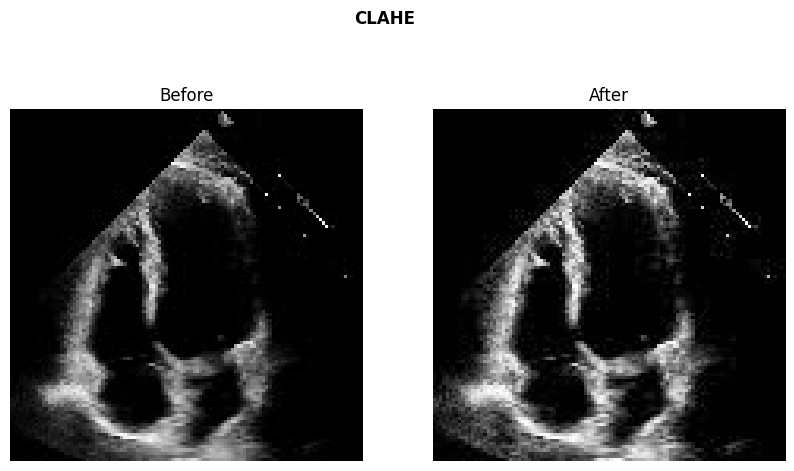

In [34]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(12, 12))
cl1 = clahe.apply(f)
print_results(f, cl1, "CLAHE")

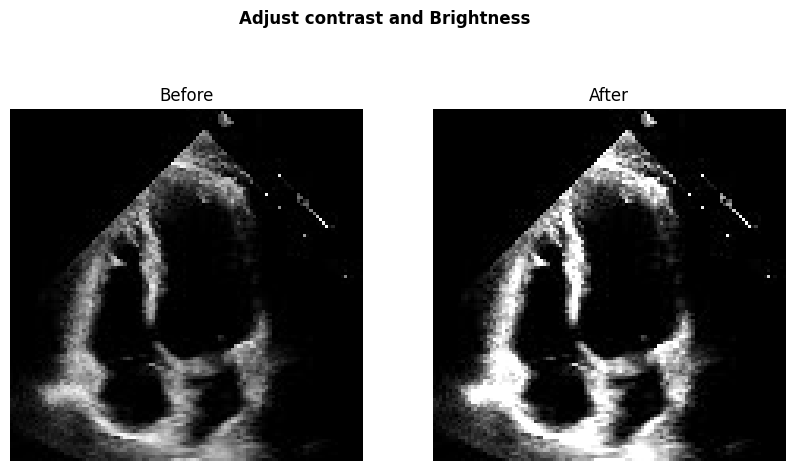

In [35]:
new_image = np.zeros(f.shape, f.dtype)
alpha = 1.0 # Simple contrast control
beta = 100 # Simple brightness control

for y in range(f.shape[0]):
  for x in range(f.shape[1]):
    new_image[y,x,] = np.clip(alpha*f[y,x] + beta, 0, 255)

print_results(f, new_image, "Adjust contrast and Brightness")

132


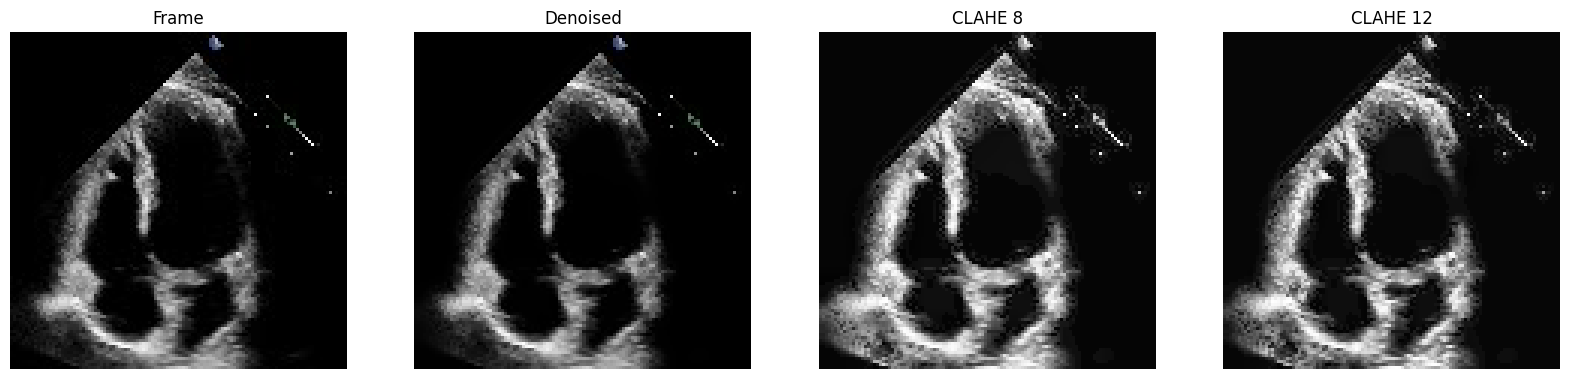

148


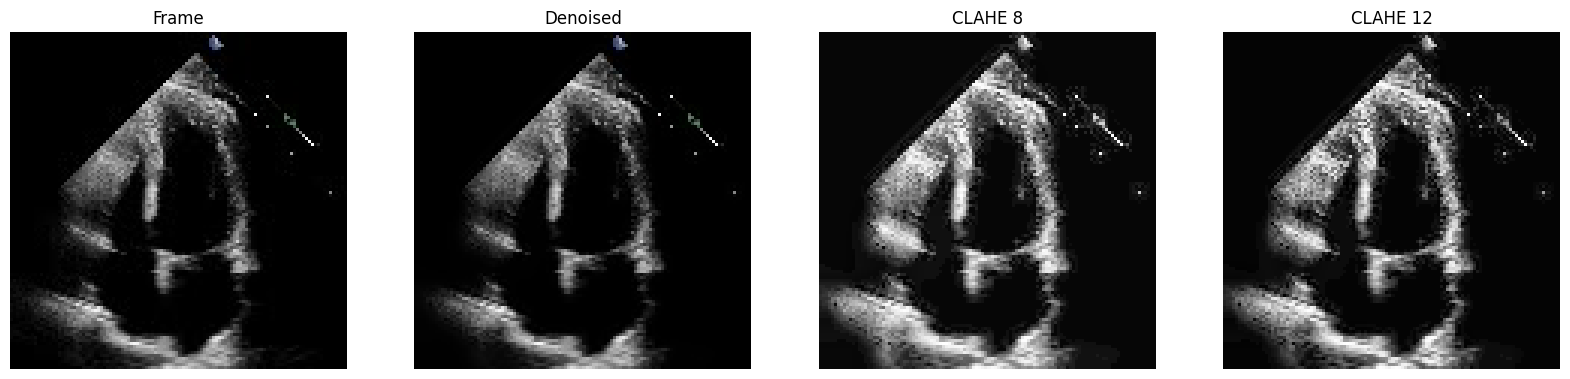

In [77]:

count = 0

for frame_code in frame_codes:
  cap = cv.VideoCapture(f"{DATA_PATH}/Videos/{file_name}")
  success, frame = cap.read()

  print(frame_code)

  while success:
    success, frame = cap.read()
    if count == frame_code-2:
      img = [cap.read()[1] for i in range(5)]
      success = False
    count += 1

  # Denoise 3rd frame considering all the 5 frames
  dst = cv.fastNlMeansDenoisingMulti(img, 2, 5, None, 4, 7, 35)

  plt.figure(figsize=(20,5))
  plt.subplot(141), plt.axis("off"), plt.title("Frame"), plt.imshow(img[2],'gray')
  plt.subplot(142), plt.axis("off"), plt.title("Denoised"), plt.imshow(dst,'gray')

  gray_dst = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
  clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
  cl1 = clahe.apply(gray_dst)

  plt.subplot(143), plt.axis("off"), plt.title("CLAHE 8"), plt.imshow(cl1,'gray')

  gray_dst = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
  clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(12, 12))
  cl1 = clahe.apply(gray_dst)

  plt.subplot(144), plt.axis("off"), plt.title("CLAHE 12"), plt.imshow(cl1,'gray')

  plt.show()

## Check processed files

In [78]:
import os

In [79]:
DATA_DIR = "data/echonet-processed"

In [95]:
img = os.listdir(os.path.join(*[DATA_DIR, "train", "image"])); print(len(img))
msk = os.listdir(os.path.join(*[DATA_DIR, "train", "mask"])); print(len(msk))
set(img).symmetric_difference(set(msk))

14297
14296


{'.DS_Store'}

In [93]:
img = os.listdir(os.path.join(*[DATA_DIR, "test", "image"])); print(len(img))
msk = os.listdir(os.path.join(*[DATA_DIR, "test", "mask"])); print(len(msk))
set(img).symmetric_difference(set(msk))

2445
2444


{'.DS_Store'}

In [90]:
img = os.listdir(os.path.join(*[DATA_DIR, "val", "image"])); print(len(img))
msk = os.listdir(os.path.join(*[DATA_DIR, "val", "mask"])); print(len(msk))
set(img).symmetric_difference(set(msk))

2475
2474


{'.DS_Store'}